In [1]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

#### **Loading:**

In [2]:
# Loading libraries:

import numpy as np
from skimage import io,metrics
import scipy.io
import scipy.stats
from sklearn.metrics import mean_squared_error
import torchvision.transforms as transforms
import torch
import lpips
from scipy.stats import spearmanr
import math
import os
import matplotlib.pyplot as plt

In [3]:
# Mounting Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the lpips models
lpips_vgg = lpips.LPIPS(net='vgg')
lpips_alex = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 41.6MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 69.8MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


#### **Function:**

In [5]:
mtlb_file = scipy.io.loadmat('/content/drive/MyDrive/hw5_unzipped/hw5.mat')

# Human Opinion Scores
blur_dmos = mtlb_file['blur_dmos'][0]
# Loading indicators
blur_orgs = mtlb_file['blur_orgs'][0]

# reference image name in refimgs folder for every distorted image in gblur folder
refnames_blur = []
for i in range(len(mtlb_file['refnames_blur'][0])):
    refnames_blur.append(mtlb_file['refnames_blur'][0][i][0])

In [8]:
def load_data(filename):
    if os.path.exists(filename):
        return np.load(filename, allow_pickle='TRUE').item()
    else:
        return dict()

def compute_metrics(distorted_img, ref_img):
    # Human Rating
    human_rating = blur_dmos[i]

    # Computing MSE
    mse_val = mean_squared_error(distorted_img.flatten(), ref_img.flatten())

    # Computing PSNR
    max_i = 255.0
    psnr_val = 20 * math.log10(max_i) - 10 * math.log10(mse_val)

    # Computing SSIM
    ssim_val = metrics.structural_similarity(distorted_img, ref_img, channel_axis=-1)

    # Computing LPIPS
    lpips_vgg_val = lpips_vgg.forward(torch.Tensor(distorted_img).T, torch.Tensor(ref_img).T)[0][0][0][0].item()
    lpips_alex_val = lpips_alex.forward(torch.Tensor(distorted_img).T, torch.Tensor(ref_img).T)[0][0][0][0].item()

    return mse_val, psnr_val, ssim_val, lpips_vgg_val, lpips_alex_val, human_rating

# Load data
mse_dict = load_data('mse_directory.npy')
psnr_dict = load_data('psnr_directory.npy')
ssim_dict = load_data('ssim_directory.npy')
lpips_vgg_dict = load_data('lpips_vgg_directory.npy')
lpips_alex_dict = load_data('lpips_alex_directory.npy')
human_score_dict = load_data('human_directory.npy')

# Compute metrics
for i, filename in enumerate(refnames_blur):
    # reading distorted image from gblur folder
    distorted_img = io.imread('/content/drive/MyDrive/hw5_unzipped/gblur/img'+str(i+1)+'.bmp')
    # reading corresponding reference image from refnames folder
    ref_img = io.imread('/content/drive/MyDrive/hw5_unzipped/refimgs/'+refnames_blur[i])

    # checking if image from gblur folder is the original. If yes, then skip to next iteration
    og = blur_orgs[i]
    if og == 0:
        mse_val, psnr_val, ssim_val, lpips_vgg_val, lpips_alex_val, human_rating = compute_metrics(distorted_img, ref_img)

        # adding metrics for img_i to respective dictionaries
        mse_dict[i] = mse_val
        psnr_dict[i] = psnr_val
        ssim_dict[i] = ssim_val
        lpips_vgg_dict[i] = lpips_vgg_val
        lpips_alex_dict[i] = lpips_alex_val
        human_score_dict[i] = human_rating

# Save data
np.save('mse_directory.npy', mse_dict)
np.save('psnr_directory.npy', psnr_dict)
np.save('ssim_directory.npy', ssim_dict)
np.save('lpips_vgg_directory.npy', lpips_vgg_dict)
np.save('lpips_alex_directory.npy', lpips_alex_dict)
np.save('human_directory.npy', human_score_dict)


<ipython-input-8-98eba93e806d>:22: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  lpips_vgg_val = lpips_vgg.forward(torch.Tensor(distorted_img).T, torch.Tensor(ref_img).T)[0][0][0][0].item()


In [9]:
# Printing Values:
print(mse_dict)
print(psnr_dict)
print(ssim_dict)
print(lpips_vgg_dict)
print(lpips_alex_dict)
print(human_score_dict)

{0: 18.619425455729168, 1: 38.29385742990703, 2: 29.898022121853298, 3: 7.40015625, 4: 40.40846845838759, 5: 44.39657238197617, 6: 56.0427000257704, 7: 55.61910807291667, 8: 17.55499267578125, 9: 60.58839988425926, 10: 70.6199459499783, 11: 8.69183349609375, 12: 30.596029083144174, 13: 36.518126797555084, 14: 37.20243441358025, 15: 56.71368638635611, 16: 79.56417083740234, 17: 54.205934312608505, 18: 50.201898193359376, 19: 64.33393282366211, 20: 45.54455732013116, 21: 46.02108357747396, 22: 18.75170644124349, 23: 76.96864679783951, 24: 85.37301839192709, 25: 56.93292999267578, 26: 29.85240974648392, 27: 10.880131191677517, 28: 30.625306871202255, 29: 26.519354078504776, 30: 20.416605631510418, 31: 16.20815938313802, 32: 65.74134216308593, 33: 39.21958669026693, 34: 33.03555552164713, 35: 34.88387827932099, 36: 41.019009060329864, 37: 72.68576158248736, 38: 36.361351013183594, 39: 75.00613996717665, 40: 65.84263486144152, 41: 30.053014081790124, 42: 22.616603009259258, 43: 47.394512679

#### **Plots and Images:**

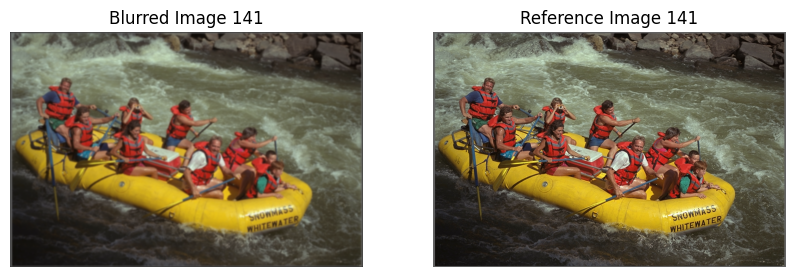

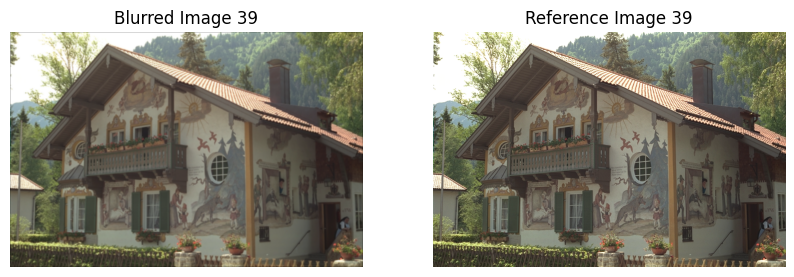

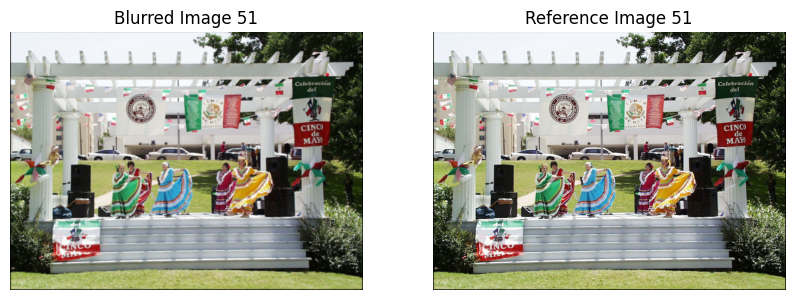

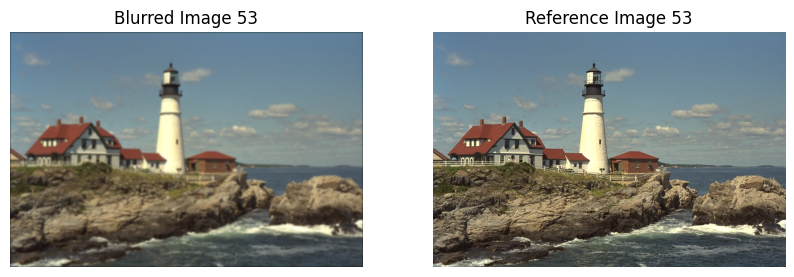

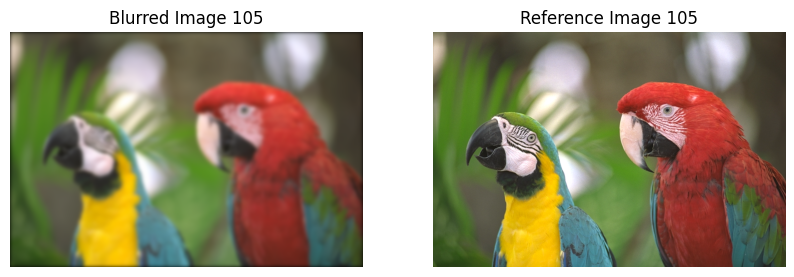

In [10]:
# Get total number of images
total_images = len(refnames_blur)

# Generate 5 random indices
random_indices = np.random.choice(total_images, 5, replace=False)

for i in random_indices:
    # reading distorted image from gblur folder
    distorted_img = io.imread('/content/drive/MyDrive/hw5_unzipped/gblur/img'+str(i+1)+'.bmp')
    # reading corresponding reference image from refnames folder
    ref_img = io.imread('/content/drive/MyDrive/hw5_unzipped/refimgs/'+refnames_blur[i])

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display distorted image
    axs[0].imshow(distorted_img)
    axs[0].set_title('Blurred Image '+str(i+1))
    axs[0].axis('off')

    # Display reference image
    axs[1].imshow(ref_img)
    axs[1].set_title('Reference Image '+str(i+1))
    axs[1].axis('off')

    plt.show()


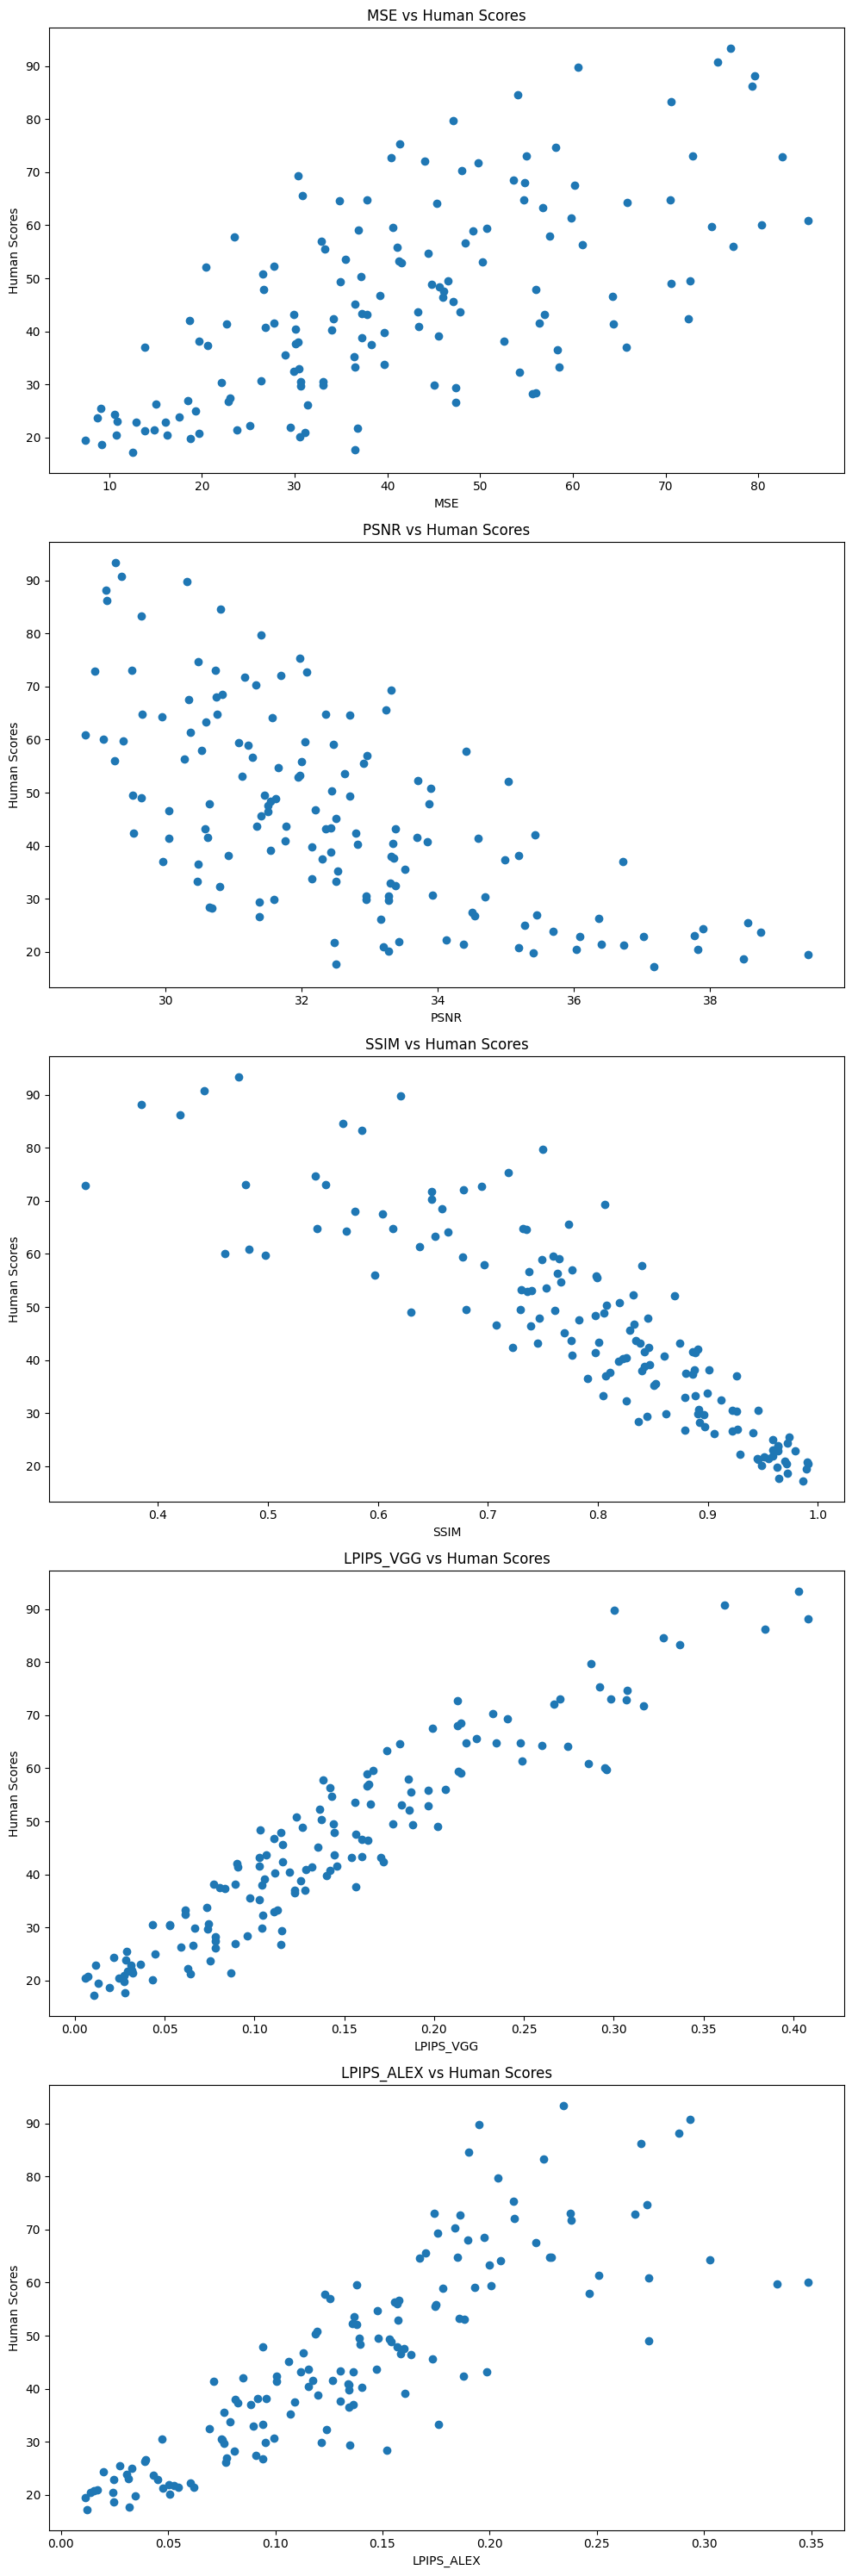

In [11]:
# Load data
mse_dict = np.load('mse_directory.npy', allow_pickle='TRUE').item()
psnr_dict = np.load('psnr_directory.npy', allow_pickle='TRUE').item()
ssim_dict = np.load('ssim_directory.npy', allow_pickle='TRUE').item()
lpips_vgg_dict = np.load('lpips_vgg_directory.npy', allow_pickle='TRUE').item()
lpips_alex_dict = np.load('lpips_alex_directory.npy', allow_pickle='TRUE').item()
human_score_dict = np.load('human_directory.npy', allow_pickle='TRUE').item()

# Convert dictionaries to lists for plotting
mse_values = list(mse_dict.values())
psnr_values = list(psnr_dict.values())
ssim_values = list(ssim_dict.values())
lpips_vgg_values = list(lpips_vgg_dict.values())
lpips_alex_values = list(lpips_alex_dict.values())
human_scores = list(human_score_dict.values())

# Create scatter plots
fig, axs = plt.subplots(5, figsize=(10, 30))

# MSE vs Human Scores
axs[0].scatter(mse_values, human_scores)
axs[0].set_title('MSE vs Human Scores')
axs[0].set_xlabel('MSE')
axs[0].set_ylabel('Human Scores')

# PSNR vs Human Scores
axs[1].scatter(psnr_values, human_scores)
axs[1].set_title('PSNR vs Human Scores')
axs[1].set_xlabel('PSNR')
axs[1].set_ylabel('Human Scores')

# SSIM vs Human Scores
axs[2].scatter(ssim_values, human_scores)
axs[2].set_title('SSIM vs Human Scores')
axs[2].set_xlabel('SSIM')
axs[2].set_ylabel('Human Scores')

# LPIPS_VGG vs Human Scores
axs[3].scatter(lpips_vgg_values, human_scores)
axs[3].set_title('LPIPS_VGG vs Human Scores')
axs[3].set_xlabel('LPIPS_VGG')
axs[3].set_ylabel('Human Scores')

# LPIPS_ALEX vs Human Scores
axs[4].scatter(lpips_alex_values, human_scores)
axs[4].set_title('LPIPS_ALEX vs Human Scores')
axs[4].set_xlabel('LPIPS_ALEX')
axs[4].set_ylabel('Human Scores')

plt.tight_layout()
plt.show()


#### **Spearman Correlation:**

In [12]:
# Load data
mse_dict = np.load('mse_directory.npy', allow_pickle='TRUE').item()
psnr_dict = np.load('psnr_directory.npy', allow_pickle='TRUE').item()
ssim_dict = np.load('ssim_directory.npy', allow_pickle='TRUE').item()
lpips_vgg_dict = np.load('lpips_vgg_directory.npy', allow_pickle='TRUE').item()
lpips_alex_dict = np.load('lpips_alex_directory.npy', allow_pickle='TRUE').item()
human_score_dict = np.load('human_directory.npy', allow_pickle='TRUE').item()

# Convert dictionaries to lists for correlation calculation
mse_values = list(mse_dict.values())
psnr_values = list(psnr_dict.values())
ssim_values = list(ssim_dict.values())
lpips_vgg_values = list(lpips_vgg_dict.values())
lpips_alex_values = list(lpips_alex_dict.values())
human_scores = list(human_score_dict.values())

# Calculate Spearman correlation
mse_corr, _ = spearmanr(mse_values, human_scores)
psnr_corr, _ = spearmanr(psnr_values, human_scores)
ssim_corr, _ = spearmanr(ssim_values, human_scores)
lpips_vgg_corr, _ = spearmanr(lpips_vgg_values, human_scores)
lpips_alex_corr, _ = spearmanr(lpips_alex_values, human_scores)

print(f"Spearman Correlation of MSE vs Human Scores: {mse_corr}")
print(f"Spearman Correlation of PSNR vs Human Scores: {psnr_corr}")
print(f"Spearman Correlation of SSIM vs Human Scores: {ssim_corr}")
print(f"Spearman Correlation of LPIPS_VGG vs Human Scores: {lpips_vgg_corr}")
print(f"Spearman Correlation of LPIPS_ALEX vs Human Scores: {lpips_alex_corr}")


Spearman Correlation of MSE vs Human Scores: 0.6607345299952763
Spearman Correlation of PSNR vs Human Scores: -0.6607345299952763
Spearman Correlation of SSIM vs Human Scores: -0.9181388757675957
Spearman Correlation of LPIPS_VGG vs Human Scores: 0.9439418989135568
Spearman Correlation of LPIPS_ALEX vs Human Scores: 0.8980278696268303


Spearman Correlation of SSIM(normalized) vs Human Scores: 0.9181388757675957


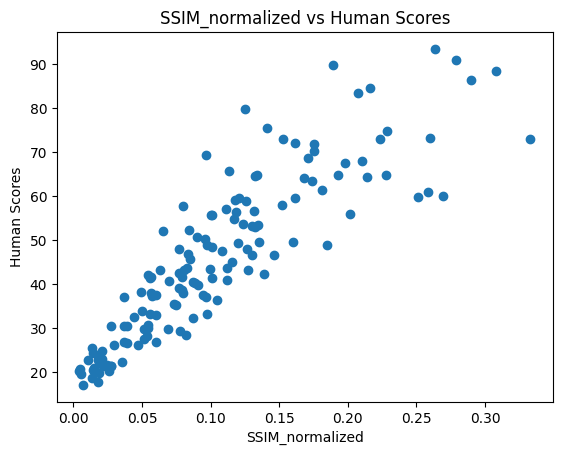

In [13]:
# After Normalizationn(For SSIM calculation)

# Load data
ssim_dict = np.load('ssim_directory.npy', allow_pickle='TRUE').item()

# Modify each value in ssim_dict
ssim_dict_normalized = {k: 1 - (1 + v) / 2 for k, v in ssim_dict.items()}

# Plotting
ssim_normalized_values = list(ssim_dict_normalized.values())

# SSIM vs Human Scores
plt.scatter(ssim_normalized_values, human_scores)
plt.title('SSIM_normalized vs Human Scores')
plt.xlabel('SSIM_normalized')
plt.ylabel('Human Scores')


# Calculate Spearman correlation:
ssim_corr_normalized, _ = spearmanr(ssim_normalized_values, human_scores)
print(f"Spearman Correlation of SSIM(normalized) vs Human Scores: {ssim_corr_normalized}")